## Diagnoza cukrzycy.

- Wykorzystanie danych z `sklearn` (jako `diab_db=datasets.load_diabetes()`);

- Podział danych na dane uczące i walidacyjne w proporcji 70% / 30%;

- Testowanie różnych rodzajów sieci z jedną oraz dwiema warstwami ukrytymi.



#### Importy

In [17]:
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Activation
from keras.activations import sigmoid, tanh, relu, linear
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from keras.initializers import HeNormal, HeUniform, GlorotNormal, GlorotUniform
from tensorflow.keras.initializers import random_uniform
from keras.losses import BinaryCrossentropy, binary_crossentropy, mse
from keras.models import clone_model
from sklearn import datasets

import matplotlib.pyplot as plt
import pandas as pd

#### Tworzenie wykresu

In [18]:
import matplotlib.pyplot as plt

def plot_print(learn_loss, test_loss, test_accur, epoches):
    fig = plt.figure()
    plt.plot(epoches, learn_loss, label='train_loss')
    plt.plot(epoches, test_loss, label='test_loss')
    plt.plot(epoches, test_accur, label='test_accur')
    plt.legend()
    plt.show()
    plt.close(1)

#### Klasy modelów sieci

In [19]:
class ModelShape:
    def __init__(self, input_shape: int, output_shape: int, hidden_layer_size, activation_input, activation_output,
                 initialization: str, learning_rate, loss, optimizer, use_bias: bool = True):
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.hidden_layer_size = hidden_layer_size
        self.activation_input = activation_input
        self.activation_output = activation_output
        self.initialization = initialization
        self.learning_rate = learning_rate
        self.loss = loss
        self.optimizer = optimizer
        self.use_bias = use_bias

    @staticmethod
    def build_model(model, input_shape):
        model.build((None, input_shape))

    @staticmethod
    def compile_model(model, optimizer, learning_rate, loss):
        optimizer = optimizer(learning_rate=learning_rate)
        model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

    @staticmethod
    def get_build_and_compiled_model(model, input_shape, optimizer, learning_rate, loss):
        ModelShape.build_model(model, input_shape)
        ModelShape.compile_model(model, optimizer, learning_rate, loss)


class BaseModel(ModelShape):
    def __init__(self, input_shape: int, output_shape: int, hidden_layer_size, activation_input, activation_output,
                 initialization: str, learning_rate, loss, optimizer, use_bias: bool = True):
        super().__init__(input_shape, output_shape, hidden_layer_size, activation_input, activation_output,
                         initialization, learning_rate, loss, optimizer, use_bias)
        self.model = None

    def create_model(self):
        self.model = Sequential()
        for hidden_layers_size in self.hidden_layer_size:
            self.model.add(Dense(hidden_layers_size, use_bias=self.use_bias,
                                 activation=self.activation_input,
                                 kernel_initializer=self.initialization,
                                 bias_initializer=self.initialization))
        self.model.add(Dense(self.output_shape, use_bias=self.use_bias, activation=self.activation_output,
                             kernel_initializer=self.initialization,
                             bias_initializer=self.initialization))

    def show_summary(self):
        return self.model.summary()


class ActivationInputAndInitModel:
    def __init__(self, activation, initialization):
        self.initialization = initialization
        self.activation = activation

#### Trening sieci i testowanie - zapisywanie wyników

In [20]:
def model_training_epoches(all_models, model_names, test_number, max_epochs, epochs_step, batch_size, data_learn_x,
                           data_learn_y, data_test_x, data_test_y, file_name="data_models_training.txt"):

    models_scores = {}
    for model, model_name in zip(all_models, model_names):
        # val_loss_model = []
        learn_loss_all = []
        test_loss_all = []
        test_accur_all = []
        epochs_all = [epoc for epoc in range(0, max_epochs + 1, epochs_step)]
        min_test_loss = []
        max_result_all = []
        min_test_epoches = []
        stop_training_epoches = {}
        stop_training_epoches_mean = max_epochs

        for test_nr in range(test_number):
            model_test = clone_model(model.model)
            ModelShape.get_build_and_compiled_model(model_test, model.input_shape, model.optimizer,
                                                    model.learning_rate, model.loss)
            test_loss_first = 1
            # learn_loss_first = 1
            test_loss_dec = 0
            # bigger_los_difference = 0
            learn_loss = []
            test_loss = []
            test_result = []
            for epoch in range(0, max_epochs + 1, epochs_step):
                # Training
                model_test.fit(data_learn_x, data_learn_y, epochs=epochs_step, verbose=0, batch_size=batch_size)

                # Tests and save results
                learn_loss.append(model_test.evaluate(data_learn_x, data_learn_y, verbose=0))
                tst_lss, tst_result = model_test.evaluate(data_test_x, data_test_y, verbose=0)
                test_loss.append(tst_lss)
                test_result.append(tst_result)
                # learn_loss_second = learn_loss

                # Stop learning if loss on the test data starts to rise.
                # Currently, I only save the epoch when we "should" stop learning.
                test_loss_second = test_loss[-1]
                if test_loss_first < test_loss_second:
                    test_loss_dec += 1
                # if (test_loss_first - learn_loss_first) / test_loss_first < (test_loss_second - learn_loss_second) / test_loss_second
                if epoch > 50 and test_loss_dec == 3:
                    stop_training_epoches[test_nr] = epoch
                    # break
                test_loss_first = test_loss_second

            # Plots data
            learn_loss_all.append(learn_loss)
            test_loss_all.append(test_loss)
            test_accur_all.append(test_result)
            min_test_loss.append(np.min(np.array(test_loss)))
            max_result_all.append(np.max(np.array(test_result)))
            min_test_epoches.append(epochs_all[test_loss.index(min_test_loss[-1])])
            # val_loss_model.append(test_loss[-1])

        # Save results
        models_scores[model_name] = [np.mean(min_test_loss), np.mean(max_result_all),
                                     np.mean(np.array(min_test_epoches))]
        stop_training_epoches_mean = np.mean(np.array(list(stop_training_epoches.values())))

        # Calculate plots data
        learn_loss_to_plot = np.mean(np.array(learn_loss_all), axis=0)
        test_loss_to_plot = np.mean(np.array(test_loss_all), axis=0)
        test_accur_to_plot = np.mean(np.array(test_accur_all), axis=0)
        print("MODEL:")
        print(model_name)
        print("Uśrednione wyniki modelu: \n")
        plot_print(learn_loss_to_plot[:, 0].tolist(), test_loss_to_plot.tolist(),
                   test_accur_to_plot.tolist(), epochs_all[:len(test_loss_to_plot)])
        print(f'Przerwanie średnio w epoce: {stop_training_epoches_mean}')
        print("Wyniki [best_test_loss, best_test_accurate, best_epoch]:")
        print(f'{models_scores[model_name]}\n')

        print("\nOstatnie uczenie i wyniki modelu: \n")
        plot_print((np.array(learn_loss)[:, 0]).tolist(), test_loss,
                   test_result, epochs_all[:len(test_loss_to_plot)])
        print("Wyniki [best_test_loss, best_test_accurate, best_epoch]:")
        print(f'[{min_test_loss[-1]}, {max_result_all[-1]}, {min_test_epoches[-1]}]')
        if test_number - 1 in stop_training_epoches:
            print(f'Przerwanie w epoce: {stop_training_epoches[test_number - 1]}\n')
        print('\n\n')

    return models_scores

#### Przygotowanie danych do uczenia i testowania

In [23]:
data = pd.read_csv('pima-indians-diabetes.data.csv')
data_learn_count = int(0.7 * len(data))
data_learn = np.asarray(data[:data_learn_count])
data_learn_x = data_learn[:, :-1]
data_learn_y = data_learn[:, -1:]

data_test = np.asarray(data[data_learn_count:])
data_test_x = data_test[:, :-1]
data_test_y = data_test[:, -1:]

#### Tworzenie modeli sieci o określonych parametrach - prezentowane są dwie sieci (jedna jednowarstwowa i jedna dwuwarstwowa), które miały najlepsze wyniki podczas testowania

In [24]:
learning_rates = [0.001]

hidden_layer_sizes = [[100]]
hidden_layers_sizes = [[100, 50]]

model_names = []
small_models = []
big_models = []

for learning_rate in learning_rates:
    for hidden_layer_size in hidden_layer_sizes:
        small_models.append(BaseModel(data_learn_x.shape[1], data_learn_y.shape[1], hidden_layer_size,
                                      'relu', 'sigmoid', 'uniform', learning_rate,
                                      binary_crossentropy, Adam))
        model_names.append(f'hidden_layer_size: {hidden_layer_size}\n'
                           f'activation_input: relu, activation_output: sigmoid,\n'
                           f'initialization: uniform\n'
                           f'learning_rate: {learning_rate}, loss_function: binary_crossentropy,\n'
                           f'optimizer: Adam\n')
        
    for hidden_layer_size in hidden_layers_sizes:
        big_models.append(BaseModel(data_learn_x.shape[1], data_learn_y.shape[1], hidden_layer_size,
                                    'relu', 'sigmoid', 'uniform', learning_rate,
                                    binary_crossentropy, Adam))
        model_names.append(f'hidden_layer_size: {hidden_layer_size}\n'
                           f'activation_input: relu, activation_output: sigmoid,\n'
                           f'initialization: uniform\n'
                           f'learning_rate: {learning_rate}, loss_function: binary_crossentropy,\n'
                           f'optimizer: Adam\n')

all_models = small_models + big_models

### Main

MODEL:
hidden_layer_size: [100]
activation_input: relu, activation_output: sigmoid,
initialization: uniform
learning_rate: 0.001, loss_function: binary_crossentropy,
optimizer: Adam

Uśrednione wyniki modelu: 



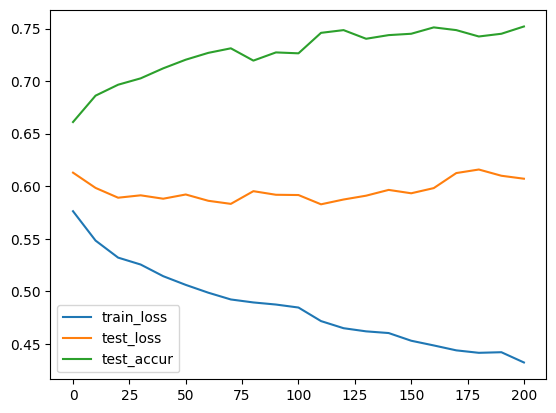

Przerwanie średnio w epoce: 74.0
Wyniki [best_test_loss, best_test_accurate, best_epoch]:
[0.5671931266784668, 0.7658008575439453, 91.0]


Ostatnie uczenie i wyniki modelu: 



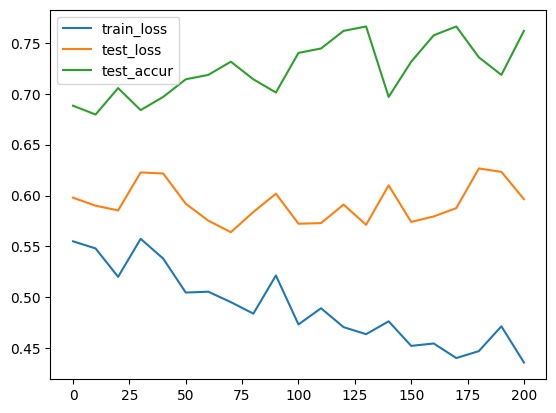

Wyniki [best_test_loss, best_test_accurate, best_epoch]:
[0.5638932585716248, 0.7662337422370911, 70]
Przerwanie w epoce: 100




MODEL:
hidden_layer_size: [100, 50]
activation_input: relu, activation_output: sigmoid,
initialization: uniform
learning_rate: 0.001, loss_function: binary_crossentropy,
optimizer: Adam

Uśrednione wyniki modelu: 



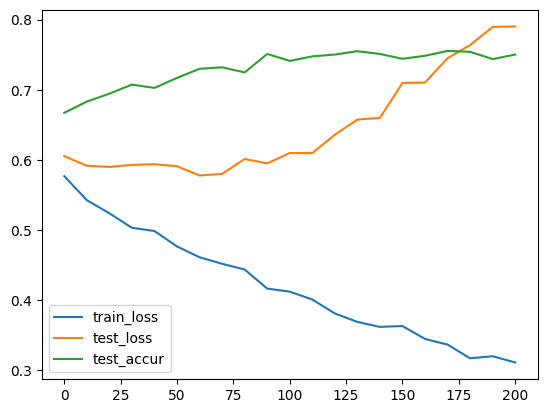

Przerwanie średnio w epoce: 68.75
Wyniki [best_test_loss, best_test_accurate, best_epoch]:
[0.5590421736240387, 0.777489185333252, 59.0]


Ostatnie uczenie i wyniki modelu: 



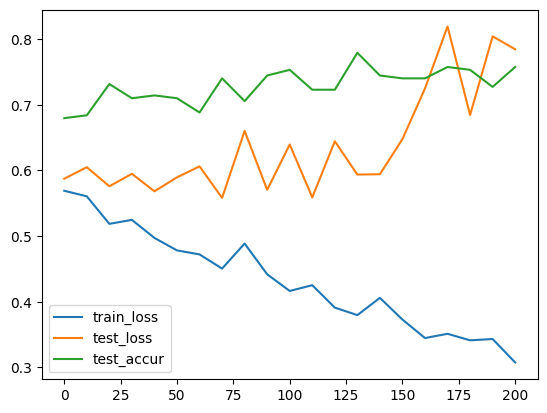

Wyniki [best_test_loss, best_test_accurate, best_epoch]:
[0.5581852197647095, 0.7792207598686218, 70]





In [25]:
for model in all_models:
    model.create_model()

test_number = 10
max_epochs = 200
epochs_step = 10
batch_size = 5
# file_name = f'data_models_training_epoches_100.txt'

models_scores = model_training_epoches(all_models, model_names, test_number, max_epochs, epochs_step, batch_size,
                                       data_learn_x, data_learn_y, data_test_x, data_test_y)

# models_scores = {k: v for k, v in sorted(models_scores.items(), key=lambda item: item[1][0])}
# for key, value in models_scores.items():
#     print(key)
#     print(f'{value}')
#     print('\n\n')         

### Największa uzyskana wartość accuracy: ok. 78%

####Korzystna konfiguracja parametrów do powyższego zadania dla obu typów sieci (z jedną i dwiema warstwami ukrytymi):<br>
Wielkość pierwszej warstwy ukrytej: ok. 100 (100 i 50 przy dwuwarstwowej);<br>
Funkcja aktywacji wejścia: relu;<br>
Funkcja aktywacji wyjścia: sigmoid;<br>
Inicjalizacja wag: uniform;<br>
Współczynnik uczenia (learning rate): 0.001; <br>
Funkcja straty (loss): binary_crossentropy; <br>
Optymalizator (optimizer): Adam.<br>

batch_size: 5

#### Wielkość warstw:<br>
Przy zwiększaniu ilości neuronów w warstwach w sieciach o dwóch warstwach ukrytych (od 100 w górę przy pierwszej warstwie - kolejna dwa razy mniejsza) wyniki nie polepszały się (jedynie najlepsze wyniki pojawiały się kilkanaście epok wcześniej). W sieciach o jednej warstwie ukrytej im więcej neuronów w warstwie (od 100 w górę) tym gorsze wyniki.<br><br>

#### Funkcje aktywacji:<br>
ReLU pomaga przy poradzeniu sobie z problemem znikającego gradientu (zanikania błędu przy niższych warstwach, co znacznie pogarsza szybkość uczenia). Jest dużo bardziej efektywna przy większej ilości warstw ukrytych. Mimo to używanie tanh jako funkcji aktywacji warstw wejściowych (ukrytych) nie odbiega wynikami znacznie od wyników relu (przy jednej i dwóch warstwach).<bt>

Sigmoid jako funkcja aktywacji warstwy wyjściowej pasuje do problemu powyższego zadania (binarnej klasyfikacji) - dzięki przedziałowi wyjściowemu 0 - 1.<br><br>

#### Inicjalizacja wag:<br>
Tutaj było sporo testów. Podobno HeNormal dobrze zgrywa się z funkcją aktywacji ReLU - w tym przypadku jednak wygrał uniform.<br><br>

#### Współczynnik uczenia:<br>
0.001 wydało się odpowiednią wartością (przy 0.01 wykresy skakały, przy 0.0001 uczenie było wolne bez znaczącej poprawy). Można jeszcze potestować wartości pośrednie między 0.001 a 0.0001.<br><br>

#### Funkcja straty (loss):<br>
Binary_crossentropy jest odpowiednia do zadań z binarną klasyfikacją.<br><br>

#### Optymalizator sieci (optimizer):<br>
Kilka testów. Adam był jednym z lepszych.<br><br>

#### Porównanie typów sieci:
Spodziewałam się, że sieć z dwoma warstwami ukrytymi poradzi sobie lepiej od sieci z jedną warstwą. Wyniki są porównywalne (dla sieci dwuwarstwowej: 100, 50 i jednowarstwowej: 100), mimo to sieć jednowarstwowa jest trochszeczkę lepsza (w wartości straty i dokładności przewidywania). Pokazuje to, że sieci o mniejszej liczbie warst mogą być w określonych przypadkach problemów lepsze od sieci o większej ich ilości (plus szybsze w uczeniu).<br><br>

#### Przerwanie uczenia:
Przerwać uczenie powinniśmy gdy wartość strat (loss) dla danych testowych zaczyna rosnąć (zamisat maleć) - przy pojawieniu się przeuczenia sieci. Trudno jednoznacznie powiedzieć kiedy to następuje - funkcja strat dla danych testowych może kilka razy wzrosnąć przed kolejnym spadkiem (możemy zatrzymac uczenie zbyt wcześnie). <br>
Można:<br>
- sprawdzać ile razy funkcja maleje (porównywać loss wcześniejszy i aktualny) - przy którymś razie zatrzymać uczenie,<br>
- sprawdzać czy loss aktualny jest większy od poprzedniego (np. określoną ilość epok wcześniej), jeśli tak - przerwać uczenie jesli współczynnik actual_loss/previous_loss będzie odpowiednio duży.<br>
- ułożyć kombinacje różnych sposobów.<br>

Zastosowany został pierwszy z wymienionych sposobów.